# **Detection et reconnaissance des maladies des arbres fruitiéres**

---

![alt text](https://cdn-images-1.medium.com/max/1200/1*FswlF4lZPQ4kT_gkybacZw.jpeg)


# Introduction

Être affecté par une maladie est très fréquent chez les plantes en raison de divers facteurs tels que les engrais, les pratiques culturales suivies, les conditions environnementales, etc. Ces maladies nuisent au rendement agricole et éventuellement à l'économie qui en découle.

Toute technique ou méthode pour surmonter ce problème et obtenir un avertissement avant que les plantes ne soient infectées aiderait les agriculteurs à cultiver efficacement des cultures ou des plantes, à la fois qualitativement et quantitativement. Ainsi, la détection des maladies chez les plantes joue un rôle très important en agriculture.


# Download Dataset


In [1]:
# Download a file based on its file ID.
file_id = '18DbC6Xj4NP-hLzI14WuMaAEyq482vNfn'

# Download dataset
!gdown https://drive.google.com/uc?id={file_id}

# Unzip the downloaded file
!unzip -q PlantVillage.zip

'gdown' n’est pas reconnu en tant que commande interne
ou externe, un programme exécutable ou un fichier de commandes.
unzip:  cannot find either PlantVillage.zip or PlantVillage.zip.zip.


# Import Libraries


Importation des bibliothèques et modules nécessaires à la construction du modèle de classification.

In [2]:
import numpy as np
import pickle
import cv2
import os
import matplotlib.pyplot as plt
from os import listdir
from sklearn.preprocessing import LabelBinarizer
from keras.models import Sequential
from keras.layers.normalization import BatchNormalization
from keras.layers.convolutional import Conv2D
from keras.layers.convolutional import MaxPooling2D
from keras.layers.core import Activation, Flatten, Dropout, Dense
from keras import backend as K
from keras.preprocessing.image import ImageDataGenerator
from keras.optimizers import Adam
from keras.preprocessing import image
from keras.preprocessing.image import img_to_array
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.model_selection import train_test_split

Using TensorFlow backend.


# Load Dataset

Initializing a few parameters required for the image dataset preprocessing.

In [3]:
# Dimension of resized image
DEFAULT_IMAGE_SIZE = tuple((256, 256))

# Number of images used to train the model
N_IMAGES = 100

# Path to the dataset folder
root_dir =  "../projet/New Plant Diseases Dataset(Augmented)/"

train_dir = os.path.join(root_dir, 'train')
val_dir = os.path.join(root_dir, 'val')

Nous utilisons la fonction `convert_image_to_array` pour redimensionner une image à la taille `DEFAULT_IMAGE_SIZE` que nous avons définie ci-dessus.

In [4]:
def convert_image_to_array(image_dir):
    try:
        image = cv2.imread(image_dir)
        if image is not None:
            image = cv2.resize(image, DEFAULT_IMAGE_SIZE)   
            return img_to_array(image)
        else:
            return np.array([])
    except Exception as e:
        print(f"Error : {e}")
        return None

Ici, nous chargeons les images de données d'apprentissage en parcourant tous les dossiers et en convertissant respectivement toutes les images et étiquettes en listes séparées.

*REMARQUE : Nous utilisons une petite partie de dataset en raison des limitations informatiques. Ajustez « N_IMAGES » pour inclure Dataset complet.*

In [5]:
image_list, label_list = [], []

try:
    print("[INFO] Loading images ...")
    plant_disease_folder_list = listdir(train_dir)

    for plant_disease_folder in plant_disease_folder_list:
        print(f"[INFO] Processing {plant_disease_folder} ...")
        plant_disease_image_list = listdir(f"{train_dir}/{plant_disease_folder}/")

        for image in plant_disease_image_list[:N_IMAGES]:
            image_directory = f"{train_dir}/{plant_disease_folder}/{image}"
            if image_directory.endswith(".jpg")==True or image_directory.endswith(".JPG")==True:
                image_list.append(convert_image_to_array(image_directory))
                label_list.append(plant_disease_folder)

    print("[INFO] Image loading completed")  
except Exception as e:
    print(f"Error : {e}")

# Transform the loaded training image data into numpy array
np_image_list = np.array(image_list, dtype=np.float16) / 225.0
print()

# Check the number of images loaded for training
image_len = len(image_list)
print(f"Total number of images: {image_len}")

[INFO] Loading images ...
[INFO] Processing Apple___Apple_scab ...
[INFO] Processing Apple___Black_rot ...
[INFO] Processing Apple___Cedar_apple_rust ...
[INFO] Processing Apple___healthy ...
[INFO] Processing Blueberry___healthy ...
[INFO] Processing Cherry_(including_sour)___healthy ...
[INFO] Processing Cherry_(including_sour)___Powdery_mildew ...
[INFO] Processing Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot ...
[INFO] Processing Corn_(maize)___Common_rust_ ...
[INFO] Processing Corn_(maize)___healthy ...
[INFO] Processing Corn_(maize)___Northern_Leaf_Blight ...
[INFO] Processing Grape___Black_rot ...
[INFO] Processing Grape___Esca_(Black_Measles) ...
[INFO] Processing Grape___healthy ...
[INFO] Processing Grape___Leaf_blight_(Isariopsis_Leaf_Spot) ...
[INFO] Processing Orange___Haunglongbing_(Citrus_greening) ...
[INFO] Processing Peach___Bacterial_spot ...
[INFO] Processing Peach___healthy ...
[INFO] Processing Pepper,_bell___Bacterial_spot ...
[INFO] Processing Pepper,_bel

Examine the labels/classes in the training dataset.

In [6]:
label_binarizer = LabelBinarizer()
image_labels = label_binarizer.fit_transform(label_list)

pickle.dump(label_binarizer,open('plant_disease_label_transform.pkl', 'wb'))
n_classes = len(label_binarizer.classes_)

print("Total number of classes: ", n_classes)

Total number of classes:  38


# Augment and Split Dataset

Utilisation de `ImageDataGenerator` pour augmenter les données en effectuant diverses opérations sur les images d'entraînement.

In [7]:
augment = ImageDataGenerator(rotation_range=25, width_shift_range=0.1,
                             height_shift_range=0.1, shear_range=0.2, 
                             zoom_range=0.2, horizontal_flip=True, 
                             fill_mode="nearest")

Splitting the data into training and test sets for validation purpose.

In [8]:
print("[INFO] Splitting data to train and test...")
x_train, x_test, y_train, y_test = train_test_split(np_image_list, image_labels, test_size=0.2, random_state = 42) 

[INFO] Splitting data to train and test...


# Build Model


Defining the hyperparameters of the plant disease classification model.

In [9]:
EPOCHS = 25
STEPS = 100
LR = 1e-3
BATCH_SIZE = 32
WIDTH = 256
HEIGHT = 256
DEPTH = 3

Creating a sequential model and adding Convolutional, Normalization, Pooling, Dropout and Activation layers at the appropriate positions.

In [10]:
model = Sequential()
inputShape = (HEIGHT, WIDTH, DEPTH)
chanDim = -1

if K.image_data_format() == "channels_first":
    inputShape = (DEPTH, HEIGHT, WIDTH)
    chanDim = 1

model.add(Conv2D(32, (3, 3), padding="same",input_shape=inputShape))
model.add(Activation("relu"))
model.add(BatchNormalization(axis=chanDim))
model.add(MaxPooling2D(pool_size=(3, 3)))
model.add(Dropout(0.25))
model.add(Conv2D(64, (3, 3), padding="same"))
model.add(Activation("relu"))
model.add(BatchNormalization(axis=chanDim))
model.add(Conv2D(64, (3, 3), padding="same"))
model.add(Activation("relu"))
model.add(BatchNormalization(axis=chanDim))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
model.add(Conv2D(128, (3, 3), padding="same"))
model.add(Activation("relu"))
model.add(BatchNormalization(axis=chanDim))
model.add(Conv2D(128, (3, 3), padding="same"))
model.add(Activation("relu"))
model.add(BatchNormalization(axis=chanDim))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dense(1024))
model.add(Activation("relu"))
model.add(BatchNormalization())
model.add(Dropout(0.5))
model.add(Dense(n_classes))
model.add(Activation("softmax"))

model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 256, 256, 32)      896       
_________________________________________________________________
activation_1 (Activation)    (None, 256, 256, 32)      0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 256, 256, 32)      128       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 85, 85, 32)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 85, 85, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 85, 85, 64)        18496     
_________________________________________________________________
activation_2 (Activation)    (None, 85, 85, 64)       

# Train Model


Nous initialisons l'optimiseur Adam avec les paramètres de taux d'apprentissage et de décroissance.

De plus, nous choisissons le type de perte et les métriques du modèle et les compilons pour l'entraînement.

In [11]:
# Initialize optimizer
opt = Adam(lr=LR, decay=LR / EPOCHS)

# Compile model
model.compile(loss="binary_crossentropy", optimizer=opt, metrics=["accuracy"])

# Train model
print("[INFO] Training network...")
history = model.fit_generator(augment.flow(x_train, y_train, batch_size=BATCH_SIZE),
                              validation_data=(x_test, y_test),
                              steps_per_epoch=len(x_train) // BATCH_SIZE,
                              epochs=EPOCHS, 
                              verbose=1)

[INFO] Training network...
Epoch 1/25
95/95 [==============================] - 874s 9s/step - loss: 0.1039 - accuracy: 0.9725 - val_loss: 0.3630 - val_accuracy: 0.9559
Epoch 2/25
95/95 [==============================] - 852s 9s/step - loss: 0.0850 - accuracy: 0.9742 - val_loss: 0.2967 - val_accuracy: 0.9613
Epoch 3/25
95/95 [==============================] - 833s 9s/step - loss: 0.0684 - accuracy: 0.9781 - val_loss: 0.3015 - val_accuracy: 0.9588
Epoch 4/25
95/95 [==============================] - 840s 9s/step - loss: 0.0599 - accuracy: 0.9803 - val_loss: 0.2984 - val_accuracy: 0.9551
Epoch 5/25
95/95 [==============================] - 825s 9s/step - loss: 0.0524 - accuracy: 0.9822 - val_loss: 0.1156 - val_accuracy: 0.9705
Epoch 6/25
95/95 [==============================] - 830s 9s/step - loss: 0.0463 - accuracy: 0.9841 - val_loss: 0.1000 - val_accuracy: 0.9732
Epoch 7/25
95/95 [==============================] - 826s 9s/step - loss: 0.0531 - accuracy: 0.9825 - val_loss: 0.1897 - val_acc

# Evaluate Model

Comparing the accuracy and loss by plotting the graph for training and validation.

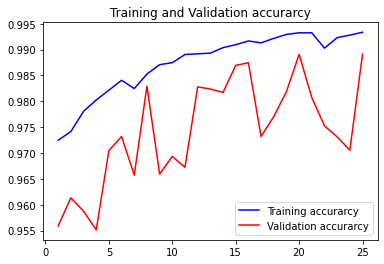

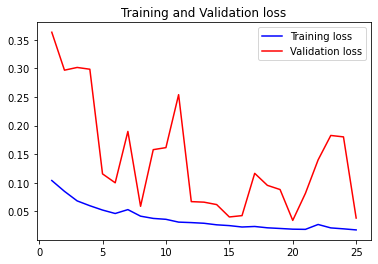

In [12]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(acc) + 1)

# Train and validation accuracy
plt.plot(epochs, acc, 'b', label='Training accurarcy')
plt.plot(epochs, val_acc, 'r', label='Validation accurarcy')
plt.title('Training and Validation accurarcy')
plt.legend()

plt.figure()

# Train and validation loss
plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and Validation loss')
plt.legend()
plt.show()

Evaluating model accuracy by using the `evaluate` method

In [13]:
print("[INFO] Calculating model accuracy")
scores = model.evaluate(x_test, y_test)
print(f"Test Accuracy: {scores[1]*100}")

[INFO] Calculating model accuracy
760/760 [==============================] - 49s 65ms/step
Test Accuracy: 98.91274571418762


# Save Model

In [14]:
# Dump pickle file of the model
print("[INFO] Saving model...")
pickle.dump(model,open('plant_disease_classification_model.pkl', 'wb'))

[INFO] Saving model...


In [15]:
# Dump pickle file of the labels
print("[INFO] Saving label transform...")
filename = 'plant_disease_label_transform.pkl'
image_labels = pickle.load(open(filename, 'rb'))

[INFO] Saving label transform...


# Test Model


We write the following `predict_disease` function to predict the class or disease of a plant image. 

We just need to provide the complete path to the image and it displays the image along with its prediction class or plant disease.

In [16]:
def predict_disease(image_path):
    image_array = convert_image_to_array(image_path)
    np_image = np.array(image_array, dtype=np.float16) / 225.0
    np_image = np.expand_dims(np_image,0)
    plt.imshow(plt.imread(image_path))
    result = model.predict_classes(np_image)
    print((image_labels.classes_[result][0]))

For testing purposes, we randomly choose images from the dataset and try predicting class or disease of the plant image.

Blueberry___healthy


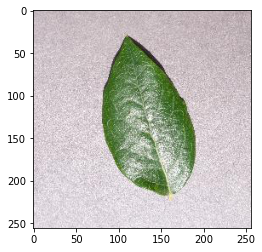

In [18]:
predict_disease('../projet/New Plant Diseases Dataset(Augmented)/valid/Blueberry___healthy/008c85d0-a954-4127-bd26-861dc8a1e6ff___RS_HL 2431.JPG')

Potato___Early_blight


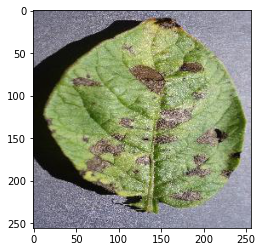

In [21]:
predict_disease('../projet/New Plant Diseases Dataset(Augmented)/valid/Potato___Early_blight/0caf6a39-3f5f-4201-a4d7-3ea35fdf1303___RS_Early.B 6762.JPG')

Apple___Apple_scab


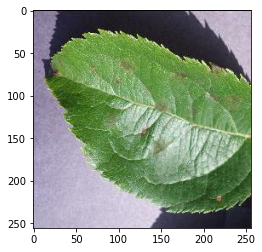

In [24]:
predict_disease('../projet/New Plant Diseases Dataset(Augmented)/valid/Apple___Apple_scab/0a6812de-7416-4ffe-aba9-307599a02c84___FREC_Scab 2973_90deg.JPG')

Orange___Haunglongbing_(Citrus_greening)


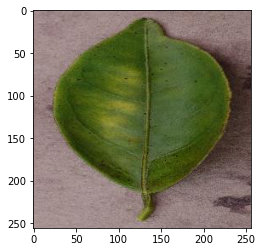

In [28]:
predict_disease('../projet/New Plant Diseases Dataset(Augmented)/valid/Orange___Haunglongbing_(Citrus_greening)/59676bab-2612-4e58-9320-5564b1014c84___CREC_HLB 3930.JPG')

# Reuse Model

We download the trained model and label transform saved in the Google Drive.

In [1]:
# Download the trained model file based on its file ID.
file_id = '1E5jNzpM__7z67GRl1cbhHK71yKcPa8wl'
!gdown https://drive.google.com/uc?id={file_id}

# Download the labels file based on its file ID.
file_id = '1WsgEd3TG33Vj_9AAAT_WfJe_AqsuC9uu'
!gdown https://drive.google.com/uc?id={file_id}

'gdown' n’est pas reconnu en tant que commande interne
ou externe, un programme exécutable ou un fichier de commandes.
'gdown' n’est pas reconnu en tant que commande interne
ou externe, un programme exécutable ou un fichier de commandes.


Importing necessary libraries and modules required to build the classification model.

In [2]:
import numpy as np
import pickle
import cv2
import os
import matplotlib.pyplot as plt
from os import listdir
from sklearn.preprocessing import LabelBinarizer
from keras.models import Sequential
from keras.layers.normalization import BatchNormalization
from keras.layers.convolutional import Conv2D
from keras.layers.convolutional import MaxPooling2D
from keras.layers.core import Activation, Flatten, Dropout, Dense
from keras import backend as K
from keras.preprocessing.image import ImageDataGenerator
from keras.optimizers import Adam
from keras.preprocessing import image
from keras.preprocessing.image import img_to_array
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.model_selection import train_test_split

Using TensorFlow backend.


Load the trained model and its labels for prediction.

In [3]:
# Load model
filename = 'plant_disease_classification_model.pkl'
model = pickle.load(open(filename, 'rb'))

# Load labels
filename = 'plant_disease_label_transform.pkl'
image_labels = pickle.load(open(filename, 'rb'))

We use the `convert_image_to_array` function to resize an image and `predict_disease` function to predict the class or disease of a plant image.

We just need to provide the complete path to the image and it displays the image along with its prediction class or plant disease.

In [4]:
# Dimension of resized image
DEFAULT_IMAGE_SIZE = tuple((256, 256))

def convert_image_to_array(image_dir):
    try:
        image = cv2.imread(image_dir)
        if image is not None:
            image = cv2.resize(image, DEFAULT_IMAGE_SIZE)   
            return img_to_array(image)
        else:
            return np.array([])
    except Exception as e:
        print(f"Error : {e}")
        return None

def predict_disease(image_path):
    image_array = convert_image_to_array(image_path)
    np_image = np.array(image_array, dtype=np.float16) / 225.0
    np_image = np.expand_dims(np_image,0)
    plt.imshow(plt.imread(image_path))
    result = model.predict_classes(np_image)
    print((image_labels.classes_[result][0]))

Cherry_(including_sour)___Powdery_mildew


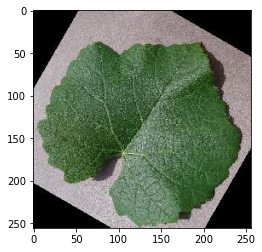

In [11]:
predict_disease('../projet/New Plant Diseases Dataset(Augmented)/valid/Grape___healthy/0c1667a2-61d7-4dee-b4d9-0d141a1ceb20___Mt.N.V_HL 9127_new30degFlipLR.JPG')